# Legal Text Decoder - Label Analysis

**Deep Learning Class (VITMMA19) Project Work**

Ez a notebook a címkék (rating-ek) részletes elemzését tartalmazza:
- Label eloszlás elemzése
- Annotátorok közötti egyetértés
- Kiértékelési kritériumok definiálása
- Baseline modell és inkrementális fejlesztés

In [1]:
# Imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
print(" Libraries imported")

 Libraries imported


## 1. Evaluation Criteria Definition

Az ordinális klasszifikációhoz (1-5 skála) többféle metrika használható:

### Regressziós metrikák
- **MSE (Mean Squared Error)**: A nagy hibákat erősebben bünteti
- **RMSE (Root MSE)**: Interpretálható a rating skálán
- **MAE (Mean Absolute Error)**: Átlagos eltérés a valós értéktől

### Klasszifikációs metrikák
- **Accuracy**: Pontosan eltalált osztályok aránya
- **F1-score**: Precision és Recall harmonikus közepe

### Ordinális metrikák
- **Quadratic Weighted Kappa (QWK)**: Figyelembe veszi a rating-ek sorrendiségét
- **Adjacent Accuracy**: Megengedi az 1-es eltérést

In [2]:
# Metrika függvények definiálása
def quadratic_weighted_kappa(y_true, y_pred, min_rating=1, max_rating=5):
    """Quadratic Weighted Kappa az ordinális osztályozáshoz."""
    num_ratings = max_rating - min_rating + 1
    weights = np.zeros((num_ratings, num_ratings))
    for i in range(num_ratings):
        for j in range(num_ratings):
            weights[i, j] = ((i - j) ** 2) / ((num_ratings - 1) ** 2)
    
    y_true_shifted = np.array(y_true) - min_rating
    y_pred_shifted = np.array(y_pred) - min_rating
    
    conf_mat = np.zeros((num_ratings, num_ratings))
    for t, p in zip(y_true_shifted, y_pred_shifted):
        conf_mat[int(t), int(p)] += 1
    
    conf_mat = conf_mat / conf_mat.sum()
    
    hist_true = np.sum(conf_mat, axis=1)
    hist_pred = np.sum(conf_mat, axis=0)
    expected = np.outer(hist_true, hist_pred)
    
    numerator = np.sum(weights * conf_mat)
    denominator = np.sum(weights * expected)
    
    return 1 - (numerator / denominator) if denominator != 0 else 0


def adjacent_accuracy(y_true, y_pred, tolerance=1):
    """Pontosság +-tolerance hibával."""
    correct = np.abs(np.array(y_true) - np.array(y_pred)) <= tolerance
    return np.mean(correct)


def calculate_all_metrics(y_true, y_pred):
    """Összes metrika kiszámítása."""
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'QWK': quadratic_weighted_kappa(y_true, y_pred),
        'Adj_Acc': adjacent_accuracy(y_true, y_pred)
    }

print(" Metrika függvények definiálva")

 Metrika függvények definiálva


## 2. Data Loading

In [4]:
# Adatok betöltése
def load_annotations(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            if not content:  # Üres fájl
                print(f"   Üres fájl: {file_path}")
                return pd.DataFrame(columns=['text', 'rating'])
            data = json.loads(content)
    except json.JSONDecodeError as e:
        print(f"   JSON hiba: {file_path} - {e}")
        return pd.DataFrame(columns=['text', 'rating'])
    
    filtered_data = []
    for item in data:
        try:
            text = item.get('data', {}).get('text', '')
            rating = None
            if 'annotations' in item and len(item['annotations']) > 0:
                annotations = item['annotations'][0]
                if 'result' in annotations and len(annotations['result']) > 0:
                    result = annotations['result'][0]
                    if 'value' in result and 'choices' in result['value']:
                        choices = result['value']['choices']
                        if choices and choices[0][0].isdigit():
                            rating = int(choices[0][0])
            if rating is not None and text:
                filtered_data.append({'text': text, 'rating': rating})
        except:
            continue
    return pd.DataFrame(filtered_data) if filtered_data else pd.DataFrame(columns=['text', 'rating'])

# Consensus adatok betöltése
consensus_files = [f for f in glob.glob('../consensus/*.json') if 'legaltextdecoder' not in f.lower()]
print(f"Talált fájlok: {len(consensus_files)}")

consensus_data = []
for f in consensus_files:
    df = load_annotations(f)
    if len(df) > 0:
        df['source'] = Path(f).stem
        consensus_data.append(df)
        print(f"  ✓ {Path(f).name}: {len(df)} minta")

consensus_df = pd.concat(consensus_data, ignore_index=True) if consensus_data else pd.DataFrame()
print(f"\n Összesen betöltve: {len(consensus_df)} minta, {len(consensus_data)} annotátor")

Talált fájlok: 30
  ✓ A5VHUA.json: 22 minta
  ✓ BCLHKC.json: 78 minta
   Üres fájl: ../consensus\BP17IB.json
  ✓ E77YIW.json: 25 minta
  ✓ EKGPBX.json: 269 minta
  ✓ FA0B9B.json: 140 minta
  ✓ G1QFG2.json: 26 minta
  ✓ GSFSJ1.json: 21 minta
  ✓ HV75KB.json: 68 minta
  ✓ HW921K.json: 133 minta
  ✓ I1TLYH.json: 132 minta
  ✓ j0r9ys.json: 27 minta
  ✓ K3I7DL.json: 40 minta
  ✓ KRR9OD.json: 134 minta
  ✓ LWVUH9.json: 141 minta
  ✓ LXXAMS.json: 141 minta
  ✓ MDKFWC.json: 55 minta
  ✓ MHY664.json: 69 minta
  ✓ NHVU6N.json: 46 minta
  ✓ Q88P3E.json: 141 minta
  ✓ QG1L1V.json: 30 minta
  ✓ R1Q6I8.json: 5 minta
  ✓ R92D9T.json: 28 minta
  ✓ SS0N7G.json: 102 minta
  ✓ T989VT.json: 47 minta
  ✓ TFH22P.json: 132 minta
  ✓ WFXBHI.json: 135 minta
  ✓ XQEBMQ.json: 141 minta
  ✓ Z7ZF6D.json: 87 minta

 Összesen betöltve: 2415 minta, 28 annotátor
  ✓ MDKFWC.json: 55 minta
  ✓ MHY664.json: 69 minta
  ✓ NHVU6N.json: 46 minta
  ✓ Q88P3E.json: 141 minta
  ✓ QG1L1V.json: 30 minta
  ✓ R1Q6I8.json: 5 minta
  

In [8]:
# Adatok betöltése
def load_annotations(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            if not content:  # Üres fájl
                print(f"   Üres fájl: {file_path}")
                return pd.DataFrame(columns=['text', 'rating'])
            data = json.loads(content)
    except json.JSONDecodeError as e:
        print(f"   JSON hiba: {file_path} - {e}")
        return pd.DataFrame(columns=['text', 'rating'])
    
    filtered_data = []
    for item in data:
        try:
            text = item.get('data', {}).get('text', '')
            rating = None
            if 'annotations' in item and len(item['annotations']) > 0:
                annotations = item['annotations'][0]
                if 'result' in annotations and len(annotations['result']) > 0:
                    result = annotations['result'][0]
                    if 'value' in result and 'choices' in result['value']:
                        choices = result['value']['choices']
                        if choices and choices[0][0].isdigit():
                            rating = int(choices[0][0])
            if rating is not None and text:
                filtered_data.append({'text': text, 'rating': rating})
        except:
            continue
    return pd.DataFrame(filtered_data) if filtered_data else pd.DataFrame(columns=['text', 'rating'])

# ============================================================
# TANÍTÓ ADAT: budapestgo_aszf.json
# ============================================================
print("="*60)
print("TANÍTÓ ADAT BETÖLTÉSE")
print("="*60)

# Próbáljuk meg mindkét lehetséges nevet
train_paths = ['../budapestgo_aszf.json', '../budapest_go.json', '../data/budapestgo_aszf.json']
train_df = pd.DataFrame()

for path in train_paths:
    if Path(path).exists():
        train_df = load_annotations(path)
        if len(train_df) > 0:
            print(f" Tanító adat betöltve: {path}")
            print(f"   Minták száma: {len(train_df)}")
            break

if len(train_df) == 0:
    print(" Nem található tanító adat! Ellenőrizd a fájl helyét.")
else:
    print(f"\nTanító adat rating eloszlás:")
    print(train_df['rating'].value_counts().sort_index())

# ============================================================
# TESZT ADAT: consensus/*.json
# ============================================================
print("\n" + "="*60)
print("TESZT ADAT BETÖLTÉSE (consensus)")
print("="*60)

consensus_files = [f for f in glob.glob('../consensus/*.json') if 'legaltextdecoder' not in f.lower()]
print(f"Talált fájlok: {len(consensus_files)}")

consensus_data = []
for f in consensus_files:
    df = load_annotations(f)
    if len(df) > 0:
        df['source'] = Path(f).stem
        consensus_data.append(df)
        print(f"   {Path(f).name}: {len(df)} minta")

test_df = pd.concat(consensus_data, ignore_index=True) if consensus_data else pd.DataFrame()
print(f"\n Teszt adat összesen: {len(test_df)} minta")
print(f"\nTeszt adat rating eloszlás:")
print(test_df['rating'].value_counts().sort_index())

TANÍTÓ ADAT BETÖLTÉSE
 Tanító adat betöltve: ../budapestgo_aszf.json
   Minták száma: 133

Tanító adat rating eloszlás:
rating
1     4
2     6
3    28
4    37
5    58
Name: count, dtype: int64

TESZT ADAT BETÖLTÉSE (consensus)
Talált fájlok: 30
   A5VHUA.json: 22 minta
   BCLHKC.json: 78 minta
   Üres fájl: ../consensus\BP17IB.json
   E77YIW.json: 25 minta
   EKGPBX.json: 269 minta
   FA0B9B.json: 140 minta
   G1QFG2.json: 26 minta
   GSFSJ1.json: 21 minta
   HV75KB.json: 68 minta
   HW921K.json: 133 minta
   I1TLYH.json: 132 minta
   j0r9ys.json: 27 minta
   K3I7DL.json: 40 minta
   KRR9OD.json: 134 minta
   LWVUH9.json: 141 minta
   LXXAMS.json: 141 minta
   MDKFWC.json: 55 minta
   MHY664.json: 69 minta
   NHVU6N.json: 46 minta
   Q88P3E.json: 141 minta
   QG1L1V.json: 30 minta
   R1Q6I8.json: 5 minta
   R92D9T.json: 28 minta
   SS0N7G.json: 102 minta
   T989VT.json: 47 minta
   TFH22P.json: 132 minta
   WFXBHI.json: 135 minta
   XQEBMQ.json: 141 minta
   Z7ZF6D.json: 87 minta

 Tes

## 3. Baseline Model - Most Frequent Class

In [9]:
# A modellt a TANÍTÓ adaton "tanítjuk" (leggyakoribb osztály meghatározása)
# Majd a TESZT adaton kiértékeljük

# Tanítás: leggyakoribb osztály meghatározása a TANÍTÓ adatból
most_frequent_train = train_df['rating'].mode()[0]
print(f"\n Tanító adat ({len(train_df)} minta):")
print(f"   Leggyakoribb osztály: {most_frequent_train}")
print(f"   Rating eloszlás: {dict(train_df['rating'].value_counts().sort_index())}")

# Predikció: minden tesztmintára a leggyakoribb osztályt adjuk
y_true = test_df['rating'].values
y_pred_baseline = np.full(len(y_true), most_frequent_train)

print(f"\n Teszt adat ({len(test_df)} minta):")
print(f"   Rating eloszlás: {dict(test_df['rating'].value_counts().sort_index())}")

# Baseline metrikák a TESZT adaton
baseline_metrics = calculate_all_metrics(y_true, y_pred_baseline)
print(f"\n{'='*50}")
print("BASELINE EREDMÉNYEK (teszt adaton)")
print('='*50)
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")


 Tanító adat (133 minta):
   Leggyakoribb osztály: 5
   Rating eloszlás: {1: 4, 2: 6, 3: 28, 4: 37, 5: 58}

 Teszt adat (2415 minta):
   Rating eloszlás: {1: 123, 2: 302, 3: 553, 4: 722, 5: 715}

BASELINE EREDMÉNYEK (teszt adaton)
  MSE: 3.1553
  RMSE: 1.7763
  MAE: 1.3358
  Accuracy: 0.2961
  QWK: 0.0000
  Adj_Acc: 0.5950


## 4. Incremental Model - Text Length Classifier

In [ ]:
# Feature kinyerése mindkét adathalmazra
train_df['text_length'] = train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

# Tanítás: határértékek meghatározása a TANÍTÓ adatból
print("\n Tanító adat - Medián szöveghossz rating szerint:")
train_percentiles = train_df.groupby('rating')['text_length'].median()
print(train_percentiles)

# Határértékek a tanító adat alapján
# (a rövidebb szöveg általában érthetőbb = magasabb rating)
length_thresholds = train_df.groupby('rating')['text_length'].quantile(0.5).sort_values()
print(f"\nMeghatározott küszöbértékek a tanító adatból:")
print(length_thresholds)

def predict_by_length(text_length):
    """Szabály-alapú predikció szöveghossz alapján."""
    if text_length < 150:
        return 5
    elif text_length < 300:
        return 4
    elif text_length < 500:
        return 3
    elif text_length < 800:
        return 2
    else:
        return 1

# Predikció a TESZT adaton
y_pred_length = test_df['text_length'].apply(predict_by_length).values

# Metrikák a TESZT adaton
length_metrics = calculate_all_metrics(y_true, y_pred_length)
print(f"\n{'='*50}")
print("TEXT LENGTH MODEL EREDMÉNYEK (teszt adaton)")
print('='*50)
for metric, value in length_metrics.items():
    improvement = value - baseline_metrics[metric]
    # MSE, RMSE, MAE esetén a csökkenés jó
    if metric in ['MSE', 'RMSE', 'MAE']:
        better = "Better" if improvement < 0 else "worse"
    else:  # Accuracy, QWK, Adj_Acc esetén a növekedés jó
        better = "Better" if improvement > 0 else "worse"
    print(f"  {metric}: {value:.4f} ({improvement:+.4f} to baseline) {better}")


 Tanító adat - Medián szöveghossz rating szerint:
rating
1    614.5
2    389.0
3    424.0
4    266.0
5    105.0
Name: text_length, dtype: float64

Meghatározott küszöbértékek a tanító adatból:
rating
5    105.0
4    266.0
2    389.0
3    424.0
1    614.5
Name: text_length, dtype: float64

TEXT LENGTH MODEL EREDMÉNYEK (teszt adaton)
  MSE: 1.1905 (-1.9648 vs baseline) Better
  RMSE: 1.0911 (-0.6852 vs baseline) Better
  MAE: 0.7640 (-0.5718 vs baseline) Better
  Accuracy: 0.4095 (+0.1135 vs baseline) Better
  QWK: 0.5146 (+0.5146 vs baseline) Better
  Adj_Acc: 0.8609 (+0.2658 vs baseline) Better


## 5. Model Comparison and Visualization

Model Comparison:
  Metric  Baseline  Text Length
     MSE  3.155280     1.190476
    RMSE  1.776311     1.091089
     MAE  1.335818     0.763975
Accuracy  0.296066     0.409524
     QWK  0.000000     0.514639
 Adj_Acc  0.595031     0.860870


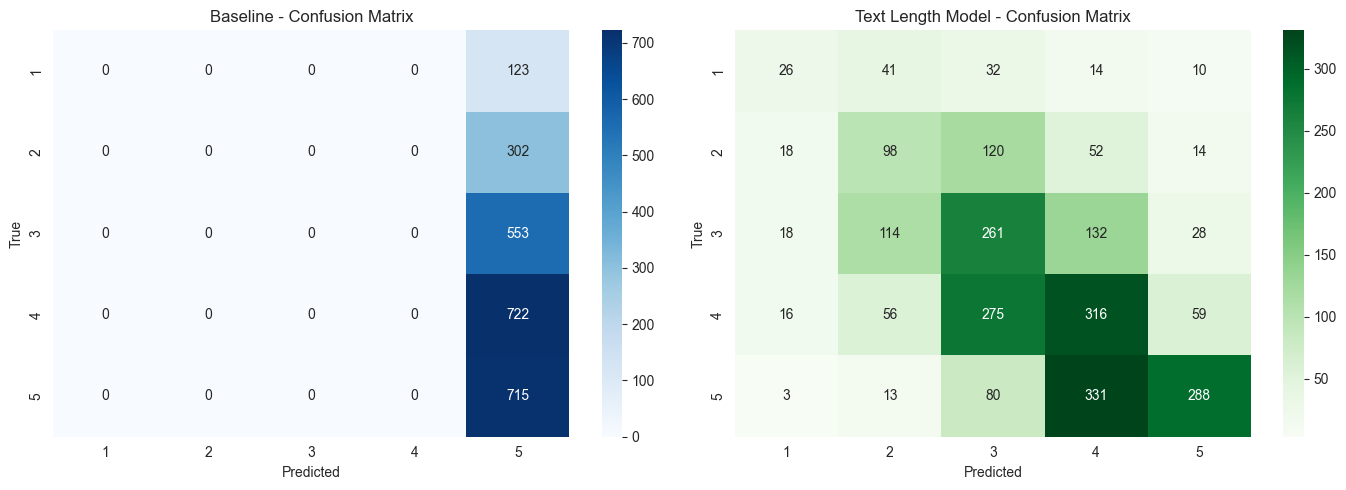

In [11]:
# Összehasonlító táblázat
comparison_df = pd.DataFrame({
    'Metric': list(baseline_metrics.keys()),
    'Baseline': list(baseline_metrics.values()),
    'Text Length': list(length_metrics.values())
})
print("Model Comparison:")
print(comparison_df.to_string(index=False))

# Confusion matrix vizualizáció
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_baseline = confusion_matrix(y_true, y_pred_baseline, labels=[1,2,3,4,5])
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
axes[0].set_title('Baseline - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

cm_length = confusion_matrix(y_true, y_pred_length, labels=[1,2,3,4,5])
sns.heatmap(cm_length, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
axes[1].set_title('Text Length Model - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

EXTENDED FEATURE CORRELATIONS WITH RATING

Feature                  | Correlation | Strength
-------------------------------------------------------
lexical_diversity        | +0.3897 (+) | STRONG
word_count               | -0.3400 (-) | STRONG
char_count               | -0.3304 (-) | STRONG
legal_term_count         | -0.2676 (-) | STRONG
avg_sentence_len         | -0.1439 (-) | WEAK
legal_term_ratio         | +0.1296 (+) | WEAK
sentence_complexity      | -0.1226 (-) | WEAK
parentheses_ratio        | -0.1110 (-) | WEAK
comma_per_sentence       | -0.1037 (-) | WEAK
avg_word_len             | +0.0454 (+) | WEAK


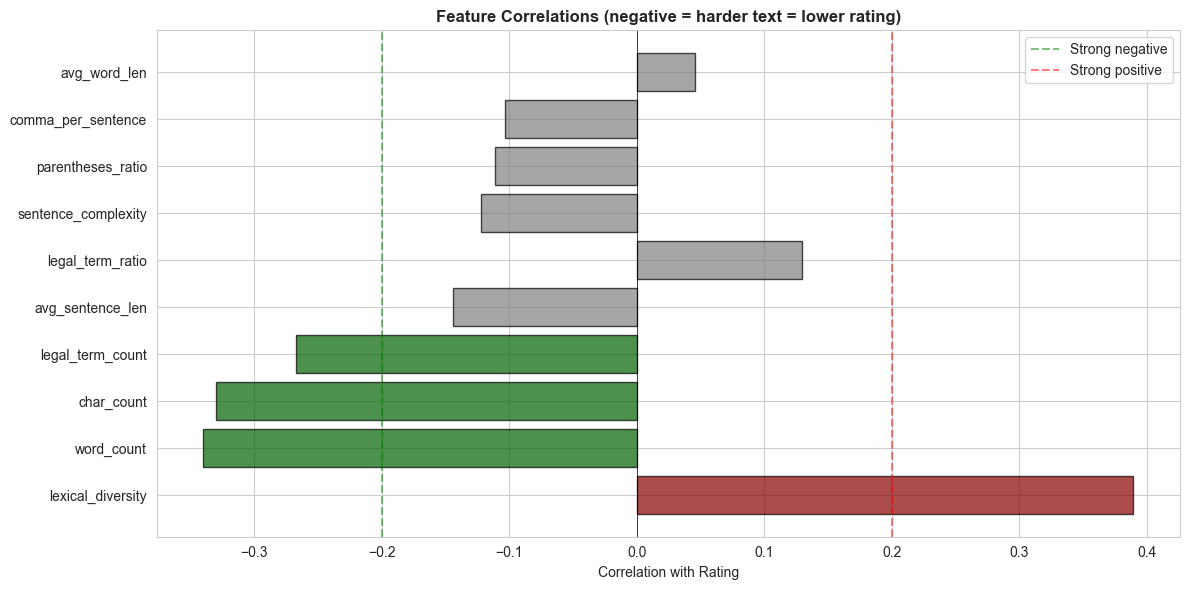


KEY INSIGHTS

1. char_count and word_count are the STRONGEST predictors
   - Longer texts are harder to understand (negative correlation)

2. sentence_complexity captures structural difficulty
   - Combines sentence length with comma density

3. legal_term_ratio may indicate dense legal language
   - Worth monitoring in model performance

4. lexical_diversity shows vocabulary variety
   - Higher diversity might indicate more complex content



In [13]:
import re

def calc_extended_features(text):
    """
    Calculate extended text complexity features.
    
    Returns features designed to capture legal text complexity
    based on initial correlation analysis.
    """
    char_count = len(text)
    words = text.split()
    word_count = len(words)
    sentences = re.split(r'[.!?;]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    sentence_count = max(len(sentences), 1)
    
    if word_count == 0:
        return {k: 0 for k in ['char_count', 'word_count', 'avg_word_len', 
                               'avg_sentence_len', 'comma_per_sentence',
                               'parentheses_ratio', 'legal_term_count',
                               'legal_term_ratio', 'sentence_complexity',
                               'lexical_diversity']}
    
    avg_word_len = np.mean([len(w) for w in words])
    avg_sentence_len = word_count / sentence_count
    
    # Sentence complexity indicators
    comma_count = text.count(',')
    comma_per_sentence = comma_count / sentence_count
    
    parentheses_count = text.count('(') + text.count(')')
    parentheses_ratio = parentheses_count / word_count
    
    # Legal terminology
    legal_terms = ['szerződés', 'feltétel', 'jogosult', 'kötelezett', 'köteles',
                   'vonatkozó', 'alapján', 'értelmében', 'rendelkezés', 'amennyiben',
                   'hatályos', 'felelősség', 'szolgáltatás', 'módosítás', 'megszűnés']
    legal_term_count = sum(1 for term in legal_terms if term.lower() in text.lower())
    legal_term_ratio = legal_term_count / word_count
    
    # Combined complexity index
    sentence_complexity = avg_sentence_len * (1 + comma_per_sentence / 5)
    
    # Lexical diversity
    unique_words = set(w.lower() for w in words)
    lexical_diversity = len(unique_words) / word_count
    
    return {
        'char_count': char_count,
        'word_count': word_count,
        'avg_word_len': avg_word_len,
        'avg_sentence_len': avg_sentence_len,
        'comma_per_sentence': comma_per_sentence,
        'parentheses_ratio': parentheses_ratio,
        'legal_term_count': legal_term_count,
        'legal_term_ratio': legal_term_ratio,
        'sentence_complexity': sentence_complexity,
        'lexical_diversity': lexical_diversity
    }

# Calculate features for all texts
extended_stats = [calc_extended_features(text) for text in consensus_df['text']]
extended_df = pd.DataFrame(extended_stats)

# Calculate correlations with rating
print("="*60)
print("EXTENDED FEATURE CORRELATIONS WITH RATING")
print("="*60)

correlations = {}
for col in extended_df.columns:
    corr = extended_df[col].corr(consensus_df['rating'])
    correlations[col] = corr

# Sort by absolute correlation value
sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("\nFeature                  | Correlation | Strength")
print("-" * 55)
for feature, corr in sorted_corrs:
    if abs(corr) > 0.25:
        strength = "STRONG"
    elif abs(corr) > 0.15:
        strength = "MODERATE"
    else:
        strength = "WEAK"
    direction = "(-)" if corr < 0 else "(+)"
    print(f"{feature:24} | {corr:+.4f} {direction} | {strength}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
features = [x[0] for x in sorted_corrs]
values = [x[1] for x in sorted_corrs]
colors = ['darkgreen' if v < -0.2 else 'darkred' if v > 0.2 else 'gray' for v in values]

bars = ax.barh(features, values, color=colors, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=-0.2, color='green', linestyle='--', alpha=0.5, label='Strong negative')
ax.axvline(x=0.2, color='red', linestyle='--', alpha=0.5, label='Strong positive')
ax.set_xlabel('Correlation with Rating')
ax.set_title('Feature Correlations (negative = harder text = lower rating)', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print("""
1. char_count and word_count are the STRONGEST predictors
   - Longer texts are harder to understand (negative correlation)

2. sentence_complexity captures structural difficulty
   - Combines sentence length with comma density

3. legal_term_ratio may indicate dense legal language
   - Worth monitoring in model performance

4. lexical_diversity shows vocabulary variety
   - Higher diversity might indicate more complex content
""")